<a href="https://colab.research.google.com/github/honghusldl/ML-DL-material-and-projects/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

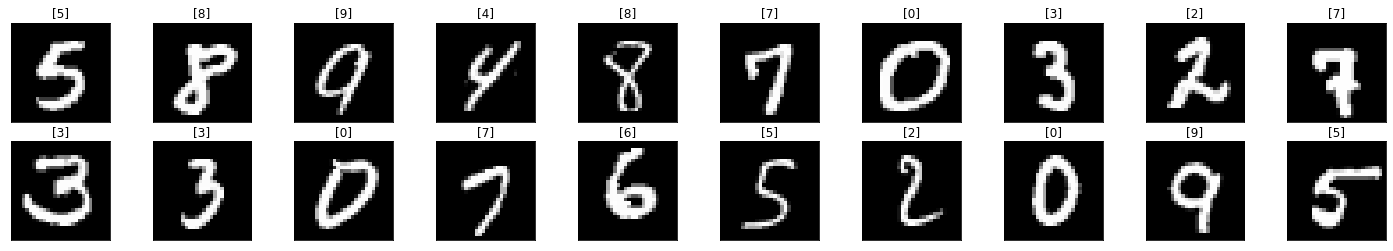

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title([labels[idx].item()])

In [6]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,20,5,1) # convolutional layer
    # 1 = 1 input
    # 20 = 20 kernels, therefore 20 in depth filtered images
    # 5 = kernel size
    # 1 = 1 stride, larger stride length may result in less effective feature extraction

    self.conv2 = nn.Conv2d(20,50,5,1)
    # 20 input from last layer
    # 50, more filters

    self.fc1 = nn.Linear(4*4*50,500) # fully connected layer
    # input images are filtered from 28*28 to 4*4, there are 50 input from last layer, hence 4*4*50

    self.dropout1 = nn.Dropout(0.5) # dropout layer is used between layers with high number of parameters
    # 0.5 is recommended value to reduce overfitting

    self.fc2 = nn.Linear(500,10)
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2) # 2*2 kernel
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2) # 2*2 kernel
    x = x.view(-1, 4*4*50) # make it flattened in fully connected layer
    # -1 = number of columns, when -1, it will be decided by machine
    # 4*4*50 = number of rows

    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x) # we dont apply activation function in the last fully connect layer since we will apply nn.crossentropyloss
    return x


In [7]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

In [9]:

epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    #inputs = inputs.view(inputs.shape[0], -1)
    # this line is not needed because in CNN the full 28*28 images are inputted 
    # we do not need to flatten them
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)

  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch : 1
training loss: 0.4915, acc 88.0983 
validation loss: 0.1467, validation acc 95.8100 
epoch : 2
training loss: 0.1254, acc 96.3517 
validation loss: 0.0840, validation acc 97.4500 
epoch : 3
training loss: 0.0841, acc 97.5250 
validation loss: 0.0610, validation acc 98.2600 
epoch : 4
training loss: 0.0645, acc 98.0617 
validation loss: 0.0483, validation acc 98.4500 
epoch : 5
training loss: 0.0534, acc 98.4050 
validation loss: 0.0416, validation acc 98.6500 
epoch : 6
training loss: 0.0457, acc 98.6233 
validation loss: 0.0404, validation acc 98.6700 
epoch : 7
training loss: 0.0391, acc 98.8383 
validation loss: 0.0402, validation acc 98.6600 
epoch : 8
training loss: 0.0351, acc 98.9433 
validation loss: 0.0336, validation acc 98.9100 
epoch : 9
training loss: 0.0314, acc 99.0450 
validation loss: 0.0297, validation acc 98.9300 
epoch : 10
training loss: 0.0276, acc 99.1917 
validation loss: 0.0293, validation acc 99.0100 
epoch : 11
training loss: 0.0251, acc 99.2350 
va

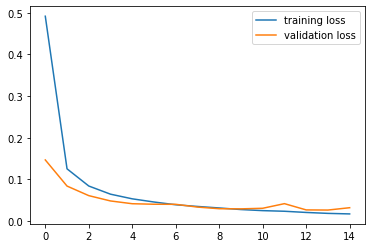

In [10]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

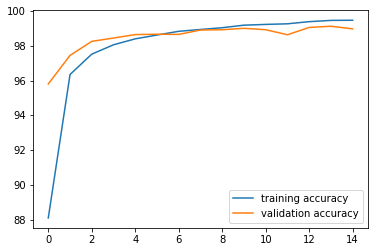

In [11]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [12]:
!pip3 install pillow==4.0.0

In [13]:
import PIL.ImageOps

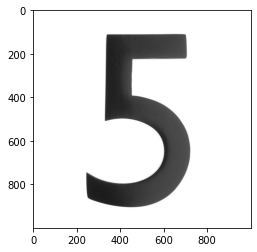

In [14]:
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

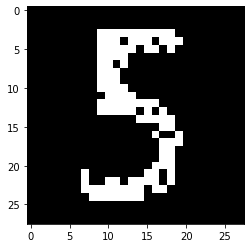

In [15]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [16]:
images = img.to(device)
image = images[0].unsqueeze(0).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(pred.item())

5


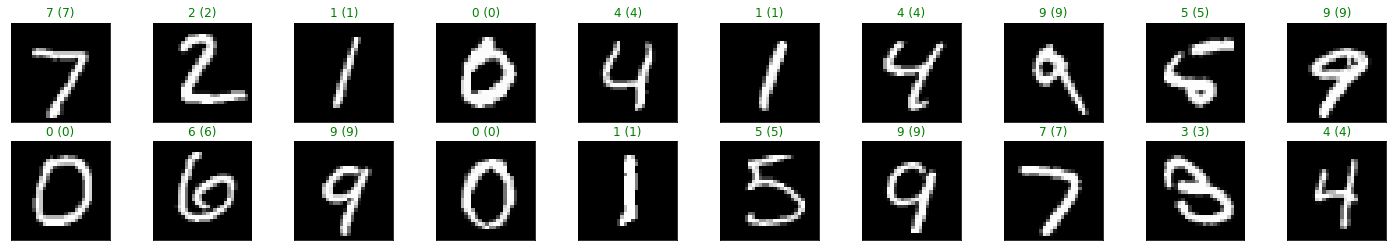

In [17]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))